# Week 4 Assignment  
## K Means Clustering

In this assignment I will be segmenting the dataset using the k means algorythm

In [1]:
%matplotlib inline

# Import libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi 
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

# Eliminate false positive SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# Make results reproducible
np.random.seed(1234567890)

df = pd.read_csv('gapminder.csv')

variables = ['incomeperperson', 'lifeexpectancy', 'internetuserate','urbanrate']
 

# convert to numeric format
for variable in variables:
    df[variable] = pd.to_numeric(df[variable], errors='coerce')

# listwise deletion of missing values
subset = df[variables].dropna()

# Print the rows and columns of the data frame
print('Size of study data')
print(subset.shape)

Size of study data
(173, 4)


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


## Data Management  

In [2]:
# Remove the first variable from the list since the target is derived from it
variables.pop(0)

# Center and scale data
for variable in variables:
    subset[variable]=preprocessing.scale(subset[variable].astype('float64'))
    
features = subset[variables]
targets = subset[['incomeperperson']]

### Split Data into Training and Test Sets  

In [3]:
training_data, test_data, training_target, test_target  = train_test_split(features, targets, test_size=.3)
print('Size of training data')
print(training_data.shape)

Size of training data
(121, 3)


## Determine the Number of Clusters

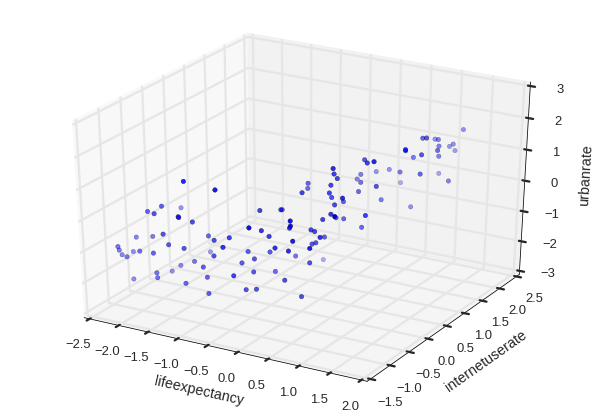

In [4]:
# Visualize the data
x = training_data.iloc[:,0]
y = training_data.iloc[:,1]
z = training_data.iloc[:,2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
ax.set_xlabel(training_data.columns.values[0], labelpad=15)
ax.set_ylabel(training_data.columns.values[1], labelpad=15)
ax.set_zlabel(training_data.columns.values[2], labelpad=15)
plt.show()

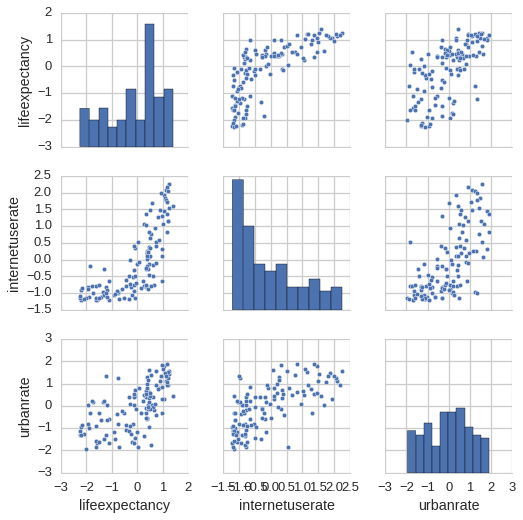

In [5]:
sns.pairplot(training_data);

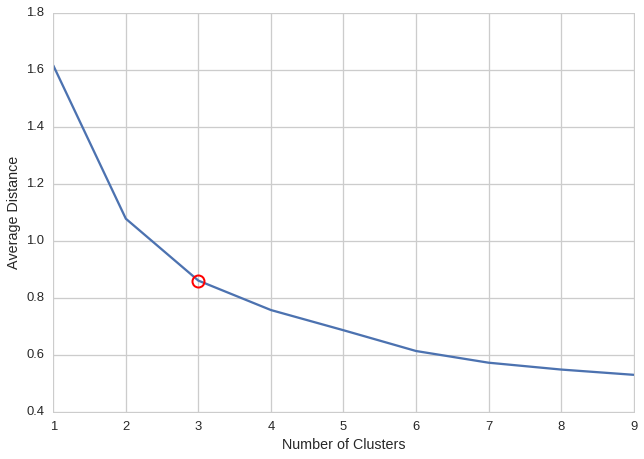

In [6]:
# Identify number of clusters using the elbow method
clusters=range(1,10)
meandist=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(training_data)
    clusassign=model.predict(training_data)
    dist = sum(np.min(cdist(training_data, model.cluster_centers_, 'euclidean'), axis=1))
    meandist.append(dist / training_data.shape[0])

# Visualize the elbow
k = 3

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(clusters, meandist)
ax.plot(clusters[(k-1)], meandist[(k-1)], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance')
plt.show()

## Visualize Clustered Data

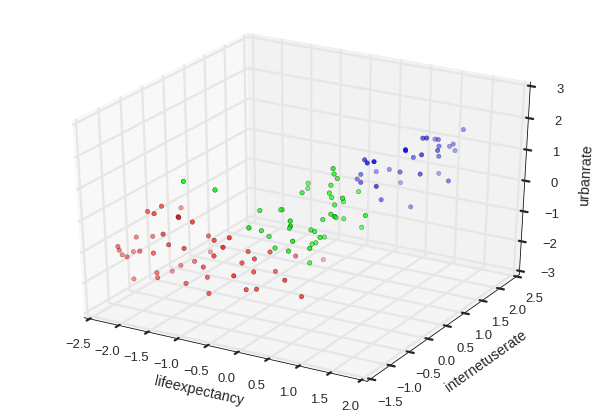

In [7]:
model=KMeans(n_clusters=k)
model.fit(training_data)
training_data['cluster'] = model.labels_
# Change Colors
my_cmap = plt.cm.get_cmap('brg')
my_cmap.set_under('w')

x = training_data.iloc[:,0]
y = training_data.iloc[:,1]
z = training_data.iloc[:,2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=training_data['cluster'], cmap=my_cmap)
ax.set_xlabel(training_data.columns.values[0], labelpad=15)
ax.set_ylabel(training_data.columns.values[1], labelpad=15)
ax.set_zlabel(training_data.columns.values[2], labelpad=15)
plt.show()

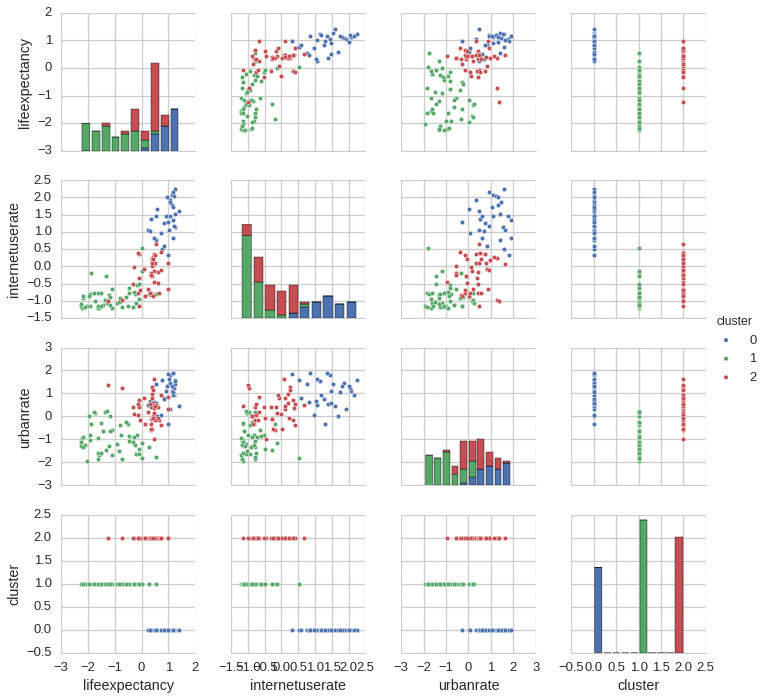

In [8]:
sns.pairplot(training_data, hue ='cluster');

## Examine Differences Between Clusters

In [9]:
# Add Cluster label to training targets
training_target['cluster'] = model.labels_
# OLS regression
income_model = smf.ols(formula='incomeperperson ~ C(cluster)', data=training_target).fit()
print (income_model.summary())

                            OLS Regression Results                            
Dep. Variable:        incomeperperson   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     109.8
Date:                Wed, 24 Feb 2016   Prob (F-statistic):           1.17e-27
Time:                        21:50:47   Log-Likelihood:                -1221.7
No. Observations:                 121   AIC:                             2449.
Df Residuals:                     118   BIC:                             2458.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept         2.01e+04   1067.431     

In [10]:
print ('means for features by cluster')
m1= training_target.groupby('cluster').mean()
print (m1)

means for features by cluster
         incomeperperson
cluster                 
0           20096.179305
1            1035.338941
2            2747.422222


In [11]:
print ('standard deviations for features by cluster')
m2= training_target.groupby('cluster').std()
print (m2)

standard deviations for features by cluster
         incomeperperson
cluster                 
0           11422.051615
1            1658.023576
2            1745.057769


In [12]:
mc1 = multi.MultiComparison(training_target['incomeperperson'], training_target['cluster'])
res1 = mc1.tukeyhsd()
print(res1.summary())

   Multiple Comparison of Means - Tukey HSD,FWER=0.05   
group1 group2   meandiff     lower       upper    reject
--------------------------------------------------------
  0      1    -19060.8404 -22311.5824 -15810.0983  True 
  0      2    -17348.7571 -20689.3716 -14008.1426  True 
  1      2     1712.0833   -1268.8099  4692.9765  False 
--------------------------------------------------------


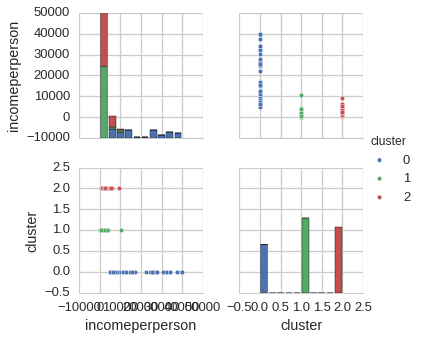

In [13]:
sns.pairplot(training_target, hue ='cluster');